In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-pog-series-s01e03/corn/sample_submission.csv
/kaggle/input/kaggle-pog-series-s01e03/corn/train.csv
/kaggle/input/kaggle-pog-series-s01e03/corn/test.csv
/kaggle/input/kaggle-pog-series-s01e03/corn/test/02578.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/15834.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/17678.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/03862.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/13412.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/03163.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/01124.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/05717.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/04084.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/02640.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/07814.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/00448.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/01686.png
/kaggle/input/kaggle-pog-series-s01e03/corn/test/07968.png
/

In [2]:
!pip install -q tensorflow==2.4.1

In [3]:
import pandas as pd 
import numpy as np 
import glob as glob
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers, preprocessing
from IPython.display import clear_output
plt.style.use('ggplot')

2023-01-25 06:39:19.726760: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
train = pd.read_csv('../input/kaggle-pog-series-s01e03/corn/train.csv')
test = pd.read_csv('../input/kaggle-pog-series-s01e03/corn/test.csv')
ss = pd.read_csv('../input/kaggle-pog-series-s01e03/corn/sample_submission.csv')

BASE_DIR = '../input/kaggle-pog-series-s01e03/corn/'

In [5]:
train.head(5)

seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored

In [6]:
train.dtypes

seed_id     int64
view       object
image      object
label      object
dtype: object

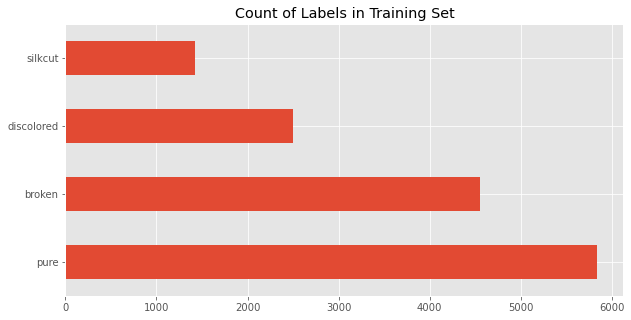

In [7]:
train['label'].value_counts().plot(kind='barh', 
                                   figsize=(10, 5), 
                                   title='Count of Labels in Training Set')

plt.show()

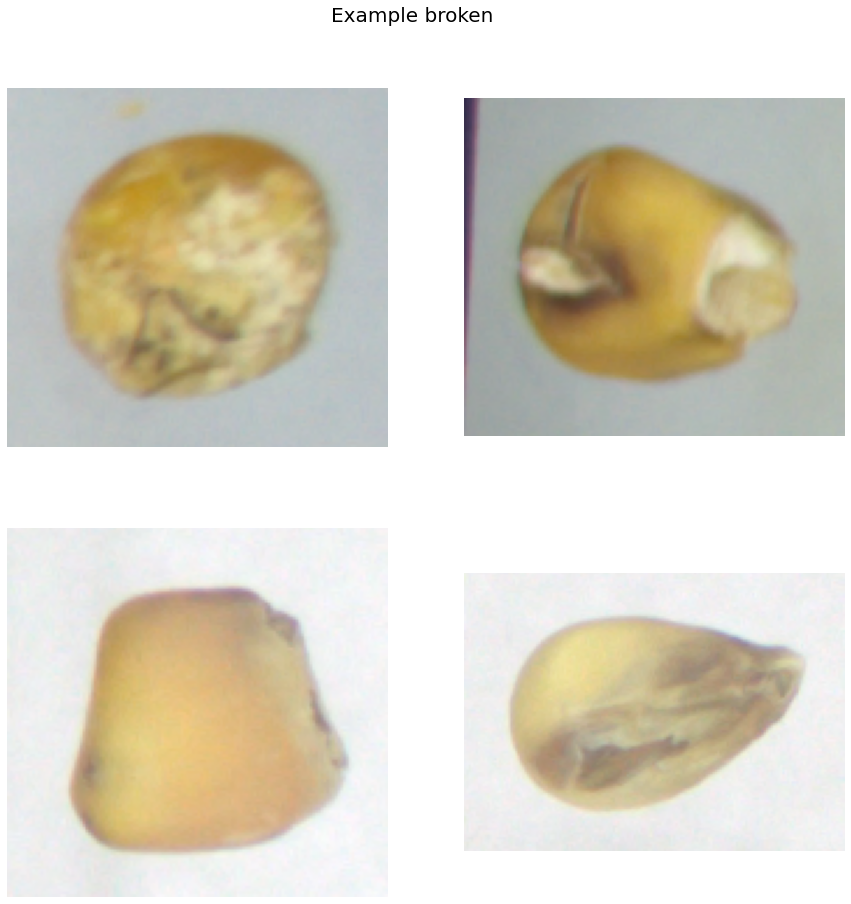

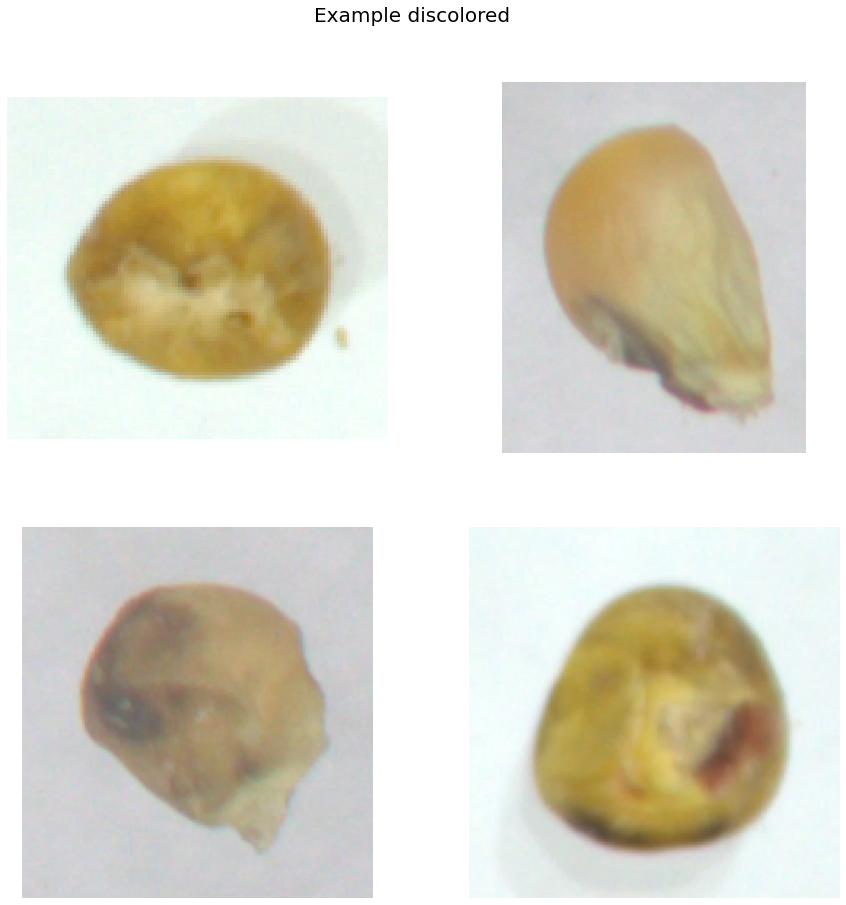

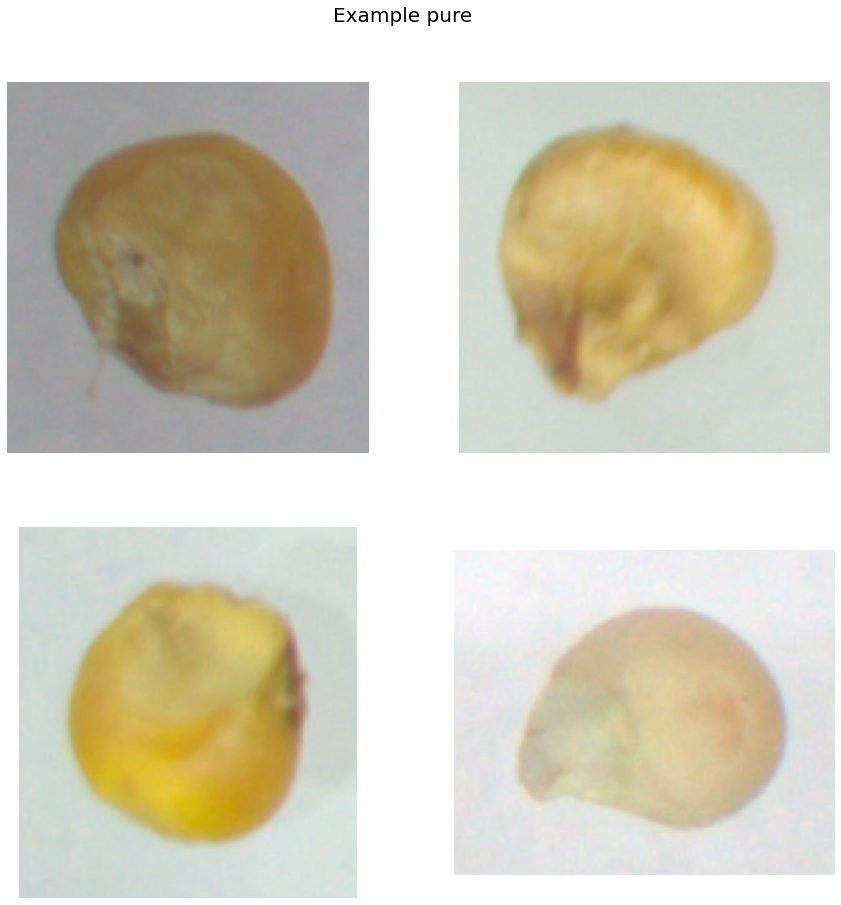

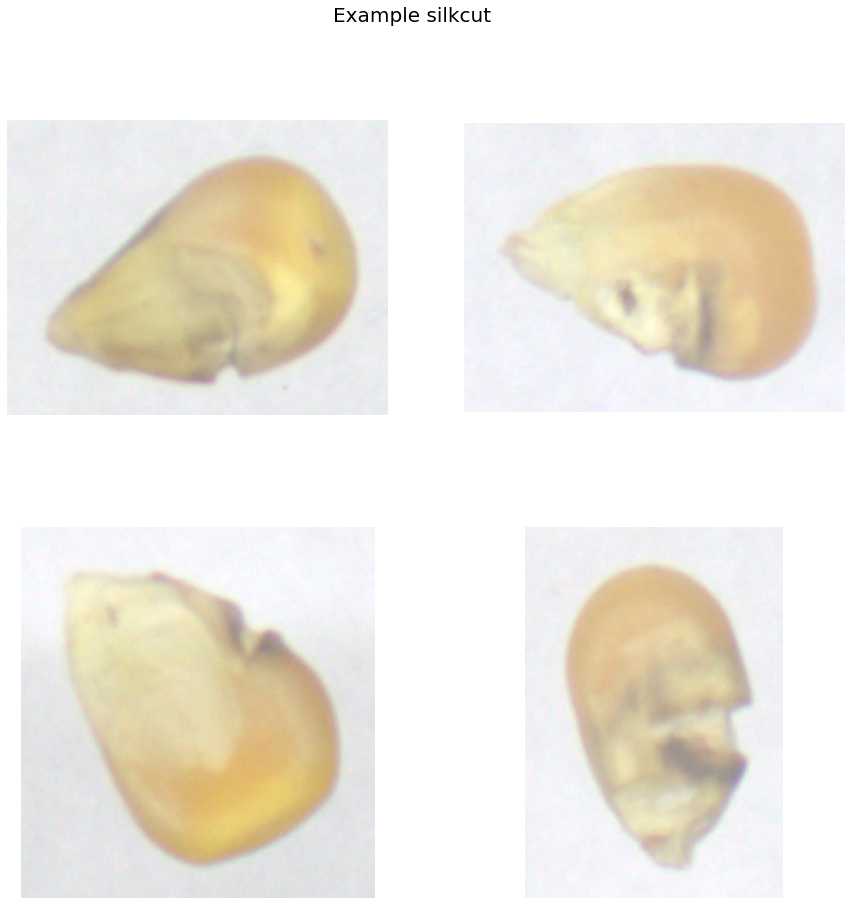

In [8]:
for label, d in train.groupby('label'):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()
    for i, fn in enumerate(d['image'].values[:4]):
        img = plt.imread(BASE_DIR + fn)
        axs[i].imshow(img)
        axs[i].axis('off')
    fig.suptitle(f'Example {label}', fontsize=20, y=0.95)
    plt.show()

In [9]:
from sklearn.model_selection import train_test_split 

In [10]:
train_ids, val_ids = train_test_split(train['seed_id'], test_size=0.2)

train.loc[train['seed_id'].isin(train_ids), 'group'] = 'train'
train.loc[train['seed_id'].isin(train_ids), 'group'] = 'val'

In [11]:
# !mkdir train
# !mkdir train/pure/ 
# !mkdir train/broken/
# !mkdir train/discolored/
# !mkdir train/silkcut/

In [12]:
import shutil
from tqdm.notebook import tqdm

In [13]:
train['img_path'] = BASE_DIR + train['image']

In [14]:
train.head(5)

seed_id    view            image       label group  \
0        0     top  train/00000.png      broken   val   
1        1  bottom  train/00001.png        pure   val   
2        3     top  train/00003.png      broken   val   
3        4     top  train/00004.png        pure   NaN   
4        5     top  train/00005.png  discolored   val   

                                            img_path  
0  ../input/kaggle-pog-series-s01e03/corn/train/0...  
1  ../input/kaggle-pog-series-s01e03/corn/train/0...  
2  ../input/kaggle-pog-series-s01e03/corn/train/0...  
3  ../input/kaggle-pog-series-s01e03/corn/train/0...  
4  ../input/kaggle-pog-series-s01e03/corn/train/0...

In [15]:
for label, d in train.groupby('label'):
    for i, d2 in tqdm(d.iterrows(), total=len(d)):
        shutil.copy(d2['img_path'], 'train/' + d2['label'])

  0%|          | 0/4554 [00:00<?, ?it/s]

  0%|          | 0/2504 [00:00<?, ?it/s]

  0%|          | 0/5837 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

In [16]:
image_size = (180, 180)
batch_size = 32 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train/',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train/',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 14322 files belonging to 4 classes.
Using 11458 files for training.


2023-01-25 06:39:39.918073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-25 06:39:39.919301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-25 06:39:40.003737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 06:39:40.004474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-01-25 06:39:40.004667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-2

Found 14322 files belonging to 4 classes.
Using 2864 files for validation.


In [17]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

2023-01-25 06:39:42.455526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-25 06:39:42.456257: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


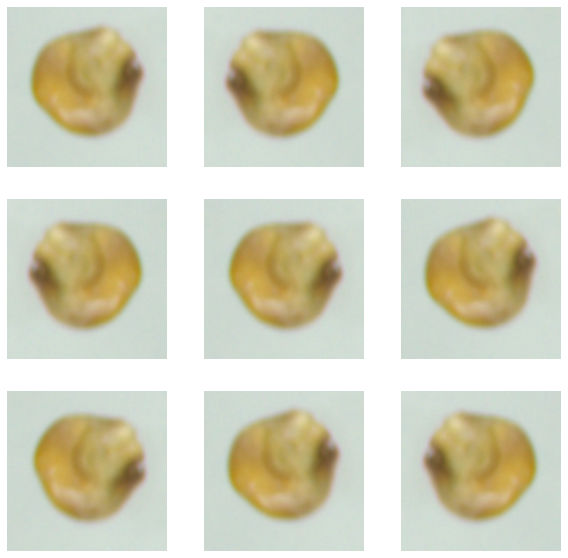

In [18]:
plt.figure(figsize=(10, 10))

for image, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(image)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [20]:
train_ds = train_ds.prefetch(buffer_size=32)

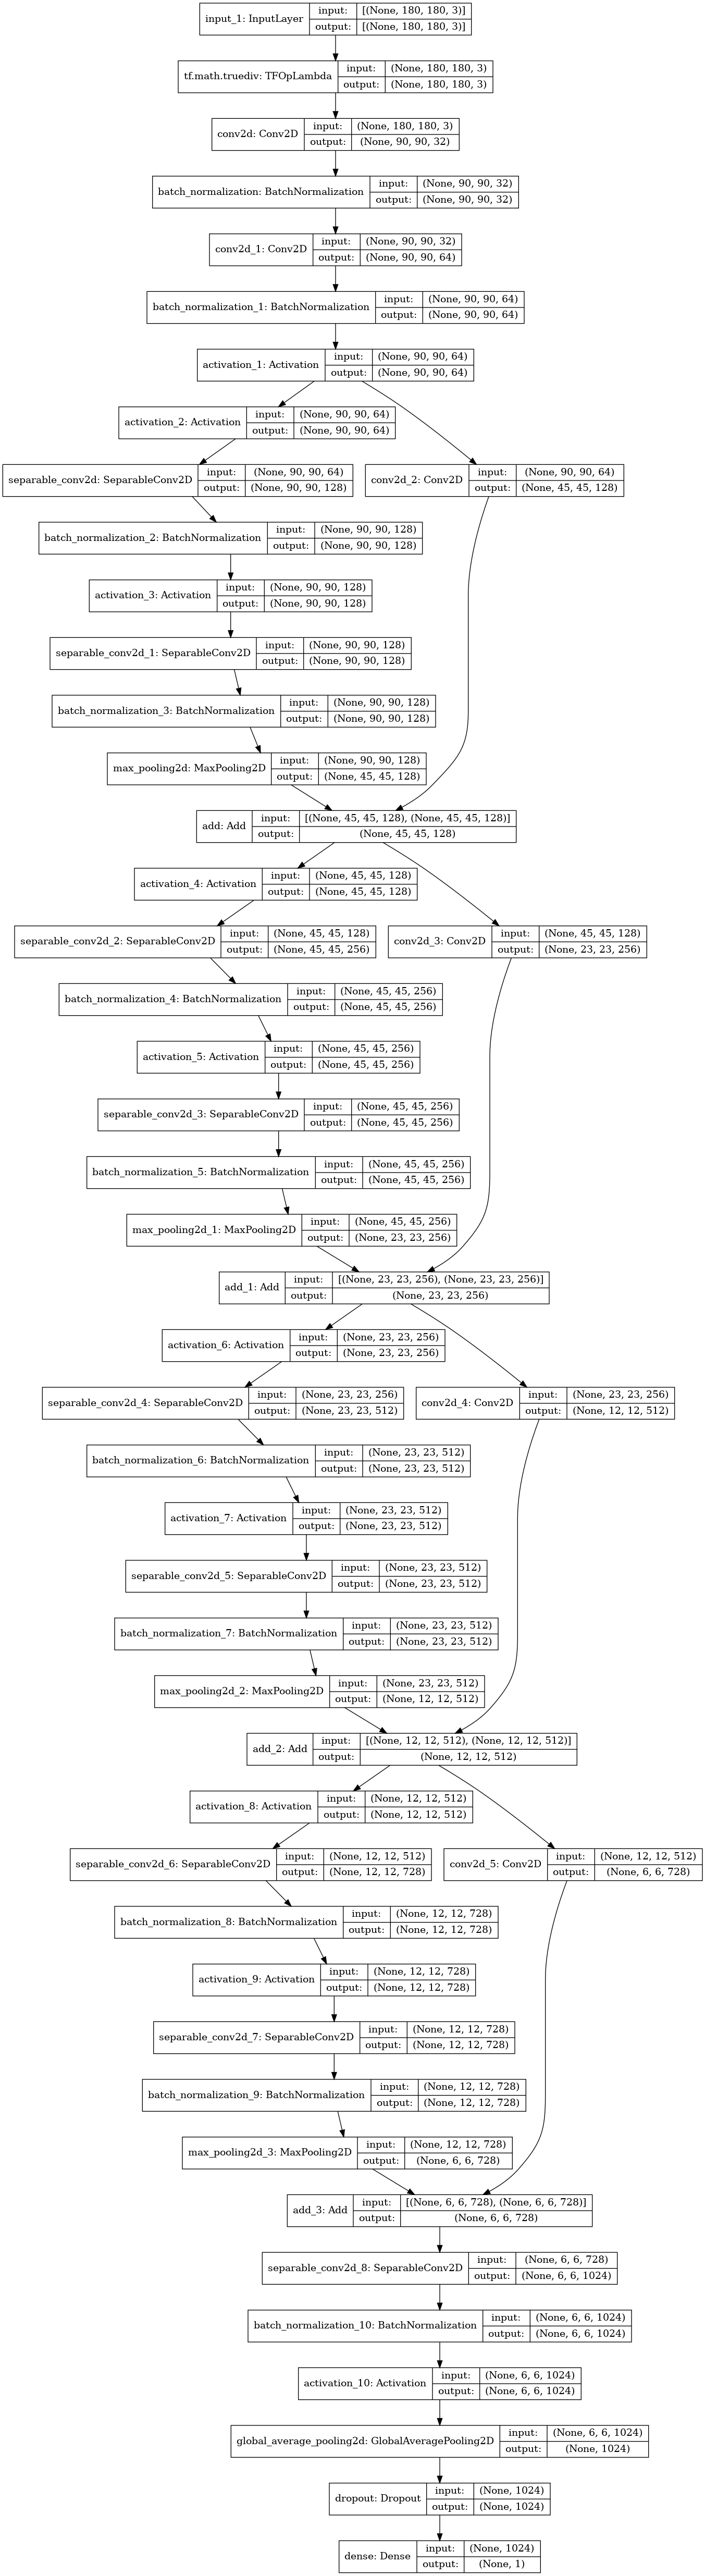

In [21]:
def model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = inputs / 255
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x - layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)


model = model(input_shape=image_size+(3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
        

In [22]:
tf.get_logger().setLevel('INFO')

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/15


2023-01-25 06:39:46.496916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-25 06:39:47.821791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-01-25 06:39:47.830713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


359/359 [==============================] - 106s 273ms/step - loss: 0.0000e+00 - accuracy: 0.2181 - val_loss: 0.0000e+00 - val_accuracy: 0.1875
Epoch 2/15
359/359 [==============================] - 96s 266ms/step - loss: 0.0000e+00 - accuracy: 0.2205 - val_loss: 0.0000e+00 - val_accuracy: 0.1819
Epoch 3/15
359/359 [==============================] - 96s 266ms/step - loss: 0.0000e+00 - accuracy: 0.2320 - val_loss: 0.0000e+00 - val_accuracy: 0.2200
Epoch 4/15
359/359 [==============================] - 96s 266ms/step - loss: 0.0000e+00 - accuracy: 0.2411 - val_loss: 0.0000e+00 - val_accuracy: 0.1892
Epoch 5/15
359/359 [==============================] - 96s 266ms/step - loss: 0.0000e+00 - accuracy: 0.2562 - val_loss: 0.0000e+00 - val_accuracy: 0.1952
Epoch 6/15
359/359 [==============================] - 96s 266ms/step - loss: 0.0000e+00 - accuracy: 0.2601 - val_loss: 0.0000e+00 - val_accuracy: 0.2277
Epoch 7/15
359/359 [==============================] - 96s 267ms/step - loss: 0.0000e+00 - ac